In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.visualize_data import view_images
from utils.learning_curves import plot_learning_curves

In [2]:
IMAGES_DIR = './images/'
TRANSPORT_DIR = os.path.join(IMAGES_DIR, 'transport/')
NOT_TRANSPORT_DIR = os.path.join(IMAGES_DIR, 'not_transport/')

In [3]:
print(TRANSPORT_DIR)
print(NOT_TRANSPORT_DIR)

./images/transport/
./images/not_transport/


In [4]:
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
NUM_CLASSES = len(os.listdir(IMAGES_DIR))

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = IMAGES_DIR,
    subset = 'training',
    seed = 1,
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE)

Found 24909 files belonging to 2 classes.
Using 19928 files for training.


In [10]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory = IMAGES_DIR,
    subset = 'validation',
    seed = 1,
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE)

Found 24909 files belonging to 2 classes.
Using 4981 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['not_transport', 'transport']


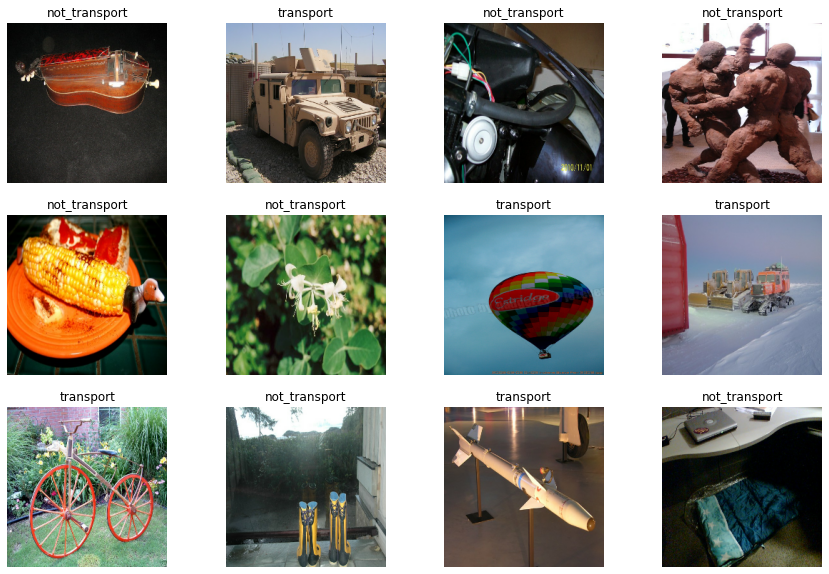

In [12]:
view_images(train_ds, class_names)

In [13]:
val_batches = tf.data.experimental.cardinality(validation_ds)

test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [14]:
print(f'Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}')
print(f'Number of test batches: {tf.data.experimental.cardinality(test_ds)}')

Number of validation batches: 125
Number of test batches: 31


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

### Data Augmentation

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape = IMG_SHAPE),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomFlip('horizontal')
])

### Transfer Learning Model (EfficientNet) 

In [76]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top = False,
    input_shape = IMG_SHAPE,
    weights = 'imagenet')

In [77]:
base_model.trainable = False

In [78]:
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES - 1, activation = 'sigmoid')(x)

In [79]:
model = tf.keras.Model(inputs, outputs)

In [80]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_6 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 512)               6558

In [81]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy'])

In [82]:
history_v1 = model.fit(
    train_ds,
    epochs = 20,
    validation_data = validation_ds)

Epoch 1/20
623/623 [==============================] - 99s 140ms/step - loss: 0.3674 - accuracy: 0.8449 - val_loss: 0.2575 - val_accuracy: 0.9110
Epoch 2/20
623/623 [==============================] - 90s 143ms/step - loss: 0.3015 - accuracy: 0.8803 - val_loss: 0.2350 - val_accuracy: 0.9168
Epoch 3/20
623/623 [==============================] - 83s 134ms/step - loss: 0.2726 - accuracy: 0.8907 - val_loss: 0.2274 - val_accuracy: 0.9210
Epoch 4/20
623/623 [==============================] - 83s 133ms/step - loss: 0.2644 - accuracy: 0.8916 - val_loss: 0.2198 - val_accuracy: 0.9158
Epoch 5/20
623/623 [==============================] - 84s 134ms/step - loss: 0.2484 - accuracy: 0.8986 - val_loss: 0.2090 - val_accuracy: 0.9263
Epoch 6/20
623/623 [==============================] - 83s 133ms/step - loss: 0.2448 - accuracy: 0.8994 - val_loss: 0.2086 - val_accuracy: 0.9243
Epoch 7/20
623/623 [==============================] - 83s 133ms/step - loss: 0.2354 - accuracy: 0.9048 - val_loss: 0.1988 - val_ac

In [83]:
train_acc = history_v1.history['accuracy']
validation_acc = history_v1.history['val_accuracy']

train_loss = history_v1.history['loss']
validation_loss = history_v1.history['val_loss']

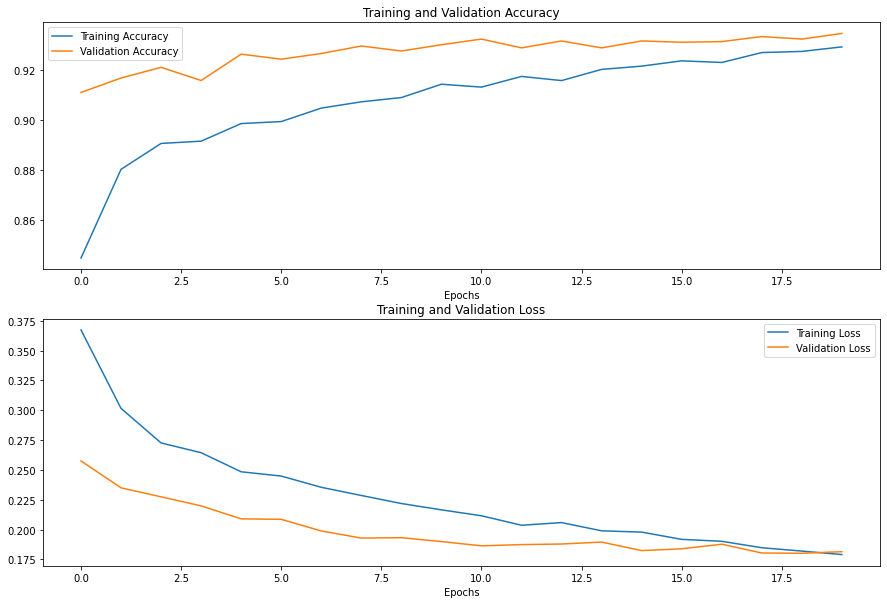

In [84]:
plot_learning_curves(train_acc, validation_acc, train_loss, validation_loss)

In [85]:
loss, accuracy = model.evaluate(test_ds, batch_size = BATCH_SIZE)
print('Loss:', loss)
print('Accuracy:', accuracy)

31/31 [==============================] - 3s 103ms/step - loss: 0.1859 - accuracy: 0.9304
Loss: 0.18593564629554749
Accuracy: 0.930443525314331


### Fine Tuning

In [86]:
base_model.trainable = True

In [87]:
print('Number of layers in the base model:', len(base_model.layers))

Number of layers in the base model: 237


In [88]:
FINE_TUNE_AT = 190

for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

In [89]:
print('Number of trainable layers:', len(base_model.trainable_variables))

Number of trainable layers: 42


In [90]:
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.00001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['Accuracy'])

In [91]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_6 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 512)               6558

In [92]:
history_v2 = model.fit(
    train_ds,
    epochs = 35,
    initial_epoch = history_v1.epoch[-1],
    validation_data = validation_ds)

Epoch 20/35
623/623 [==============================] - 117s 164ms/step - loss: 0.1704 - Accuracy: 0.9318 - val_loss: 0.1763 - val_Accuracy: 0.9356
Epoch 21/35
623/623 [==============================] - 97s 156ms/step - loss: 0.1629 - Accuracy: 0.9382 - val_loss: 0.1711 - val_Accuracy: 0.9388
Epoch 22/35
623/623 [==============================] - 99s 159ms/step - loss: 0.1590 - Accuracy: 0.9388 - val_loss: 0.1698 - val_Accuracy: 0.9371
Epoch 23/35
623/623 [==============================] - 98s 158ms/step - loss: 0.1573 - Accuracy: 0.9385 - val_loss: 0.1686 - val_Accuracy: 0.9396
Epoch 24/35
623/623 [==============================] - 99s 158ms/step - loss: 0.1503 - Accuracy: 0.9434 - val_loss: 0.1698 - val_Accuracy: 0.9388
Epoch 25/35
623/623 [==============================] - 97s 156ms/step - loss: 0.1447 - Accuracy: 0.9442 - val_loss: 0.1662 - val_Accuracy: 0.9398
Epoch 26/35
623/623 [==============================] - 99s 159ms/step - loss: 0.1466 - Accuracy: 0.9441 - val_loss: 0.1706 

In [93]:
train_acc += history_v2.history['Accuracy']
validation_acc += history_v2.history['val_Accuracy']

train_loss += history_v2.history['loss']
validation_loss += history_v2.history['val_loss']

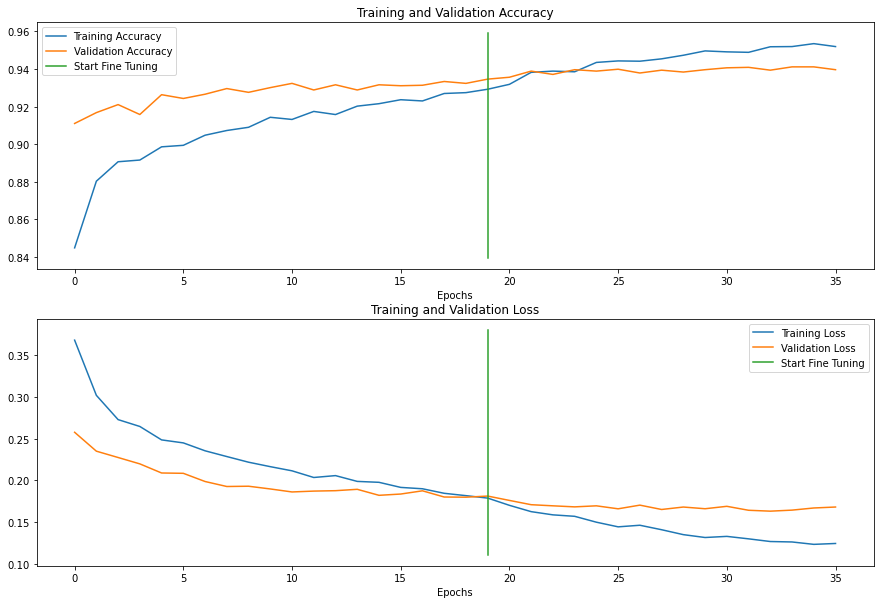

In [95]:
plot_learning_curves(train_acc, validation_acc, train_loss, validation_loss, fine_tune_epoch = 19)

In [96]:
loss, accuracy = model.evaluate(test_ds, batch_size = BATCH_SIZE)
print('Loss:', loss)
print('Accuracy:', accuracy)

31/31 [==============================] - 3s 102ms/step - loss: 0.1595 - Accuracy: 0.9476
Loss: 0.15954391658306122
Accuracy: 0.9475806355476379


In [97]:
model.save('model/efficientnet_transport.h5')

C:\Users\Karan\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
